In [1]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits

# For simulation
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

Gate error ratio: {'x': 1.0, 'rz': 0.0, 'sx': 1.0}


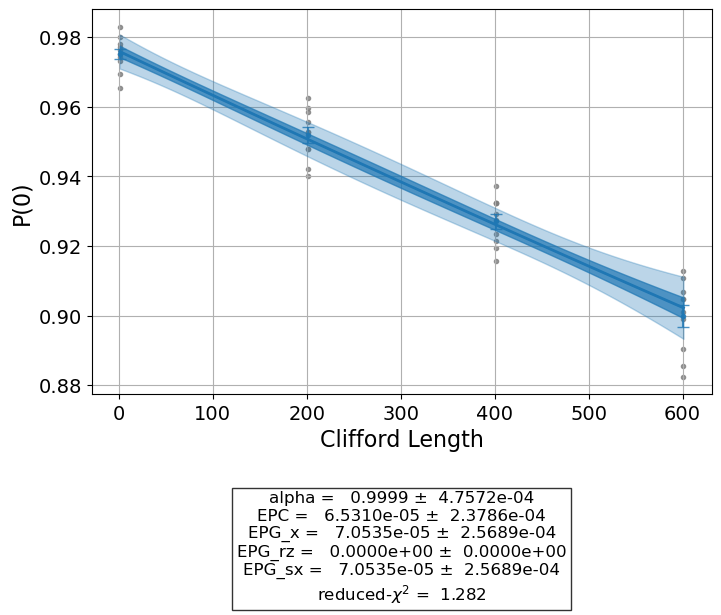

AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 134
 - degree of freedom: 1
 - chi-square: 1.2816738737141526
 - reduced chi-square: 1.2816738737141526
 - Akaike info crit.: 1.447490305351165
 - Bayesian info crit.: -0.39362661128916354
 - init params:
  * a = 0.4752586433299186
  * alpha = 0.9997123837465663
  * b = 0.5
 - fit params:
  * a = 0.9758972620919107 ± 3.4357381146386192
  * alpha = 0.9998693805380616 ± 0.00047571811983148396
  * b = 2.2836752459438014e-13 ± 3.43634672679536
 - correlations:
  * (a, b) = -0.9999999022907179
  * (alpha, b) = -0.9999375436415393
  * (a, alpha) = 0.9999339693138874
- quality: good
- extra: <2 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: alpha
- value: 0.9999+/-0.0005
- χ²: 1.2816738737141526
- quality: good
- extra: <2 items>
- device_components: [

In [2]:
lengths = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = [0]

# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

# View result data
print("Gate error ratio: %s" % expdata1.experiment.analysis.options.gate_error_ratio)
display(expdata1.figure(0))
for result in results1:
    print(result)

In [3]:
lengths_2_qubit = np.arange(1, 200, 30)
lengths_1_qubit = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = (1, 2)

# Run a 1-qubit RB experiment on qubits 1, 2 to determine the error-per-gate of 1-qubit gates
single_exps = BatchExperiment(
    [
        StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
        for qubit in qubits
    ],
    flatten_results=True,
)
expdata_1q = single_exps.run(backend).block_for_results()

Gate error ratio: {'cx': 1.0}


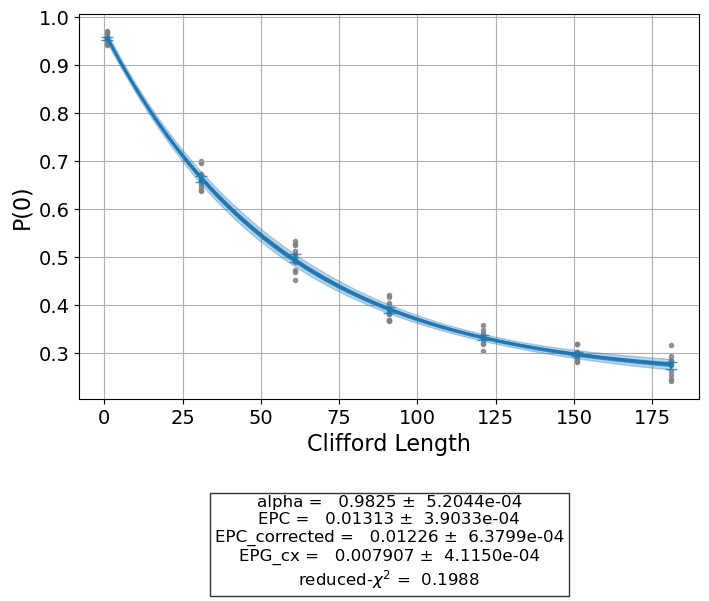

AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 20
 - degree of freedom: 4
 - chi-square: 0.7953898555091501
 - reduced chi-square: 0.19884746387728752
 - Akaike info crit.: -9.22383134505772
 - Bayesian info crit.: -9.38610089789178
 - init params:
  * a = 0.720135415309694
  * alpha = 0.9815904533406329
  * b = 0.25
 - fit params:
  * a = 0.7217159538433428 ± 0.006558793403294147
  * alpha = 0.9824885050544295 ± 0.0005204418527495479
  * b = 0.24769997235243305 ± 0.0062574007981375645
 - correlations:
  * (alpha, b) = -0.9005060322453992
  * (a, b) = -0.8299108579236131
  * (a, alpha) = 0.663008768012104
- quality: good
- extra: <2 items>
- device_components: ['Q1', 'Q2']
- verified: False
AnalysisResult
- name: alpha
- value: 0.9825+/-0.0005
- χ²: 0.19884746387728752
- quality: good
- extra: <2 items>
- device_compone

In [4]:
# Run an RB experiment on qubits 1, 2
exp_2q = StandardRB(qubits, lengths_2_qubit, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp_2q.analysis.set_options(epg_1_qubit=expdata_1q.analysis_results())

# Run the 2-qubit experiment
expdata_2q = exp_2q.run(backend).block_for_results()

# View result data
print("Gate error ratio: %s" % expdata_2q.experiment.analysis.options.gate_error_ratio)
display(expdata_2q.figure(0))
for result in expdata_2q.analysis_results():
    print(result)

## Displaying the circuit

/Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:282: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: /Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


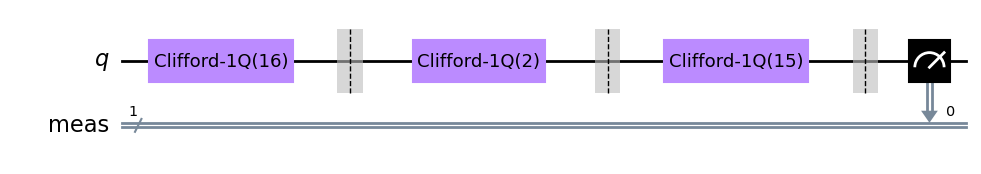

In [5]:
# Run an RB experiment on qubit 0
exp = StandardRB(physical_qubits=(0,), lengths=[2], num_samples=1, seed=seed)
c = exp.circuits()[0]
c.draw(output="mpl", style="iqp")

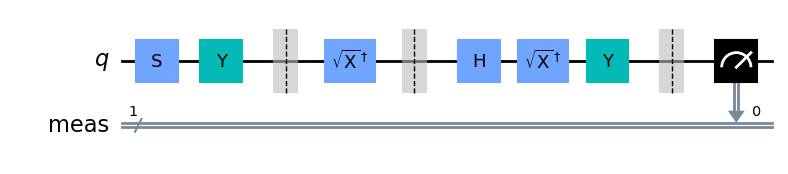

In [6]:
c.decompose().draw(output="mpl", style="iqp")

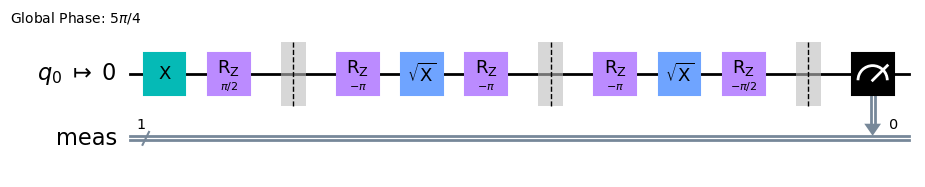

In [7]:
from qiskit import transpile
transpile(c, backend, **vars(exp.transpile_options)).draw(output="mpl", style="iqp", idle_wires=False)

## Interleaved RB experiment

In [8]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1, 2)

# The interleaved gate is the CX gate
int_exp2 = InterleavedRB(
    circuits.RZXGate(np.pi/2), qubits, lengths, num_samples=num_samples, seed=seed)

int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

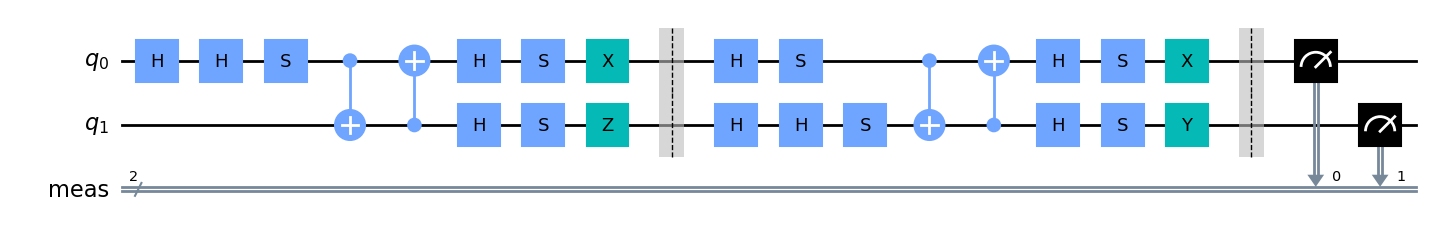

In [9]:
int_exp2.circuits()[0].decompose().draw('mpl')

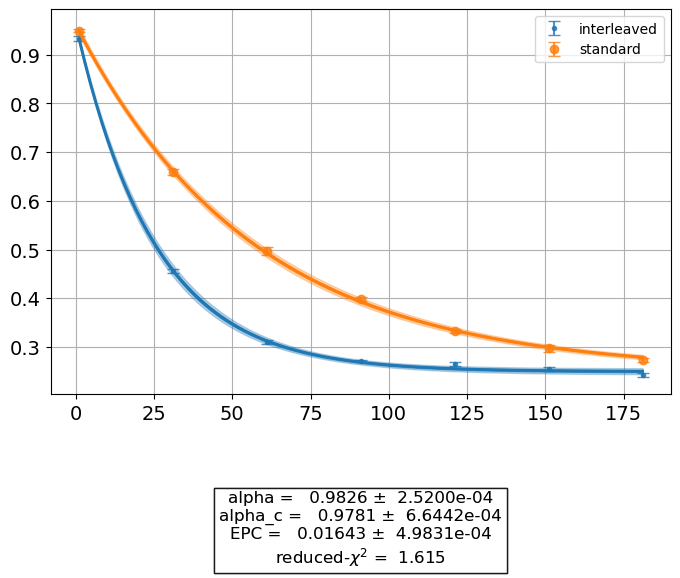

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 30
 - degree of freedom: 10
 - chi-square: 16.149219656856747
 - reduced chi-square: 1.6149219656856748
 - Akaike info crit.: 9.9994016059521
 - Bayesian info crit.: 12.555630924413133
 - init params:
  * a = 0.7090575017917023
  * alpha = 0.9812098372341125
  * b = 0.25
  * alpha_c = 0.9861177196520051
 - fit params:
  * a = 0.7109820707091786 ± 0.0033626551586561056
  * alpha = 0.9825619148145756 ± 0.0002519987437793862
  * b = 0.24998758130498938 ± 0.0020825551320172173
  * alpha_c = 0.9780895395576836 ± 0.0006644193308228298
 - correlations:
  * (alpha, b) = -0.620141289300686
  * (a, b) = -0.5166676219188531
  * (b, alpha_c) = -0.4287903012763255
  * (alpha, alpha_c) = 0.07826096714935006
  * (a, alpha) =

In [10]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)